In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Instalar la versión CORRECTA de OpenCV y luego importar

# Desinstalar primero para evitar conflictos (el -y evita la pregunta de confirmación)
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y # Asegurarse de quitar ambas si existen

# Instalar la versión que incluye los módulos contrib
!pip install opencv-contrib-python

# --- IMPORTANTE ---
# Después de ejecutar esta celda, DEBES REINICIAR EL ENTORNO DE EJECUCIÓN.
# En Colab: Ve a "Entorno de ejecución" -> "Reiniciar entorno de ejecución..."
# Luego, vuelve a ejecutar todas las celdas desde el principio.
# ------------------

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.1 MB/s eta 0:00:00


# Laboratorio Integrador: Detección de Rostros y Puntos Faciales Clave (Landmarks)

**Objetivo:** En esta práctica integradora, aplicaremos y conectaremos dos técnicas importantes de Visión por Computadora que hemos visto:

1.  **Detección de Rostros:** Utilizaremos el método de Haar Cascades para encontrar la ubicación de múltiples caras dentro de una imagen.
2.  **Detección de Landmarks Faciales:** Una vez localizadas las caras, aplicaremos un modelo más avanzado (LBF) para identificar 68 puntos clave específicos en cada rostro (ojos, cejas, nariz, boca, mandíbula).

**Contexto:** Estas técnicas son fundamentales en muchas aplicaciones, desde filtros de redes sociales y sistemas de reconocimiento facial hasta análisis de expresiones o detección de somnolencia en conductores.

**Imagen de Trabajo:** Usaremos una icónica imagen de la película argentina "Nueve Reinas".

**¡Manos a la obra!**

## Sección 0: Configuración del Entorno

Antes de comenzar, necesitamos asegurarnos de tener las librerías adecuadas y descargar los archivos necesarios (imagen, modelos pre-entrenados).

### 0.1 Instalación e Importación de Librerías

*   **`opencv-python` (`cv2`):** Librería esencial para visión por computadora.
*   **`opencv-contrib-python`:** Contiene módulos extra de OpenCV, incluyendo `cv2.face` que usaremos para los landmarks. A menudo, instalar este paquete reemplaza o incluye `opencv-python`.
*   **`matplotlib.pyplot` (`plt`):** Para visualizar imágenes dentro del cuaderno.
*   **`numpy` (`np`):** Para manejo eficiente de arrays (las imágenes son arrays).

In [3]:
# Instalar librerías (si es necesario) y luego importar
# Usamos %%capture para ocultar la salida detallada de la instalación.
#%%capture
#!pip uninstall opencv-python -y # Desinstalar versión base si existe
#!pip install matplotlib opencv-contrib-python # Instalar versión con módulos extra

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Librerías importadas.")

Librerías importadas.


### 0.2 Descarga de Recursos

Descargaremos:

1.  **Imagen:** `9reinas.jpg`.
2.  **Clasificador Haar:** `haarcascade_frontalface_default.xml`. Lo descargaremos directamente del repositorio oficial de OpenCV en GitHub. Este archivo contiene los patrones Haar pre-calculados para detectar rostros frontales.
3.  **Modelo de Landmarks LBF:** `lbfmodel.yaml`. Este es un modelo pre-entrenado específico para el algoritmo LBF (Local Binary Features) de detección de landmarks. (Usaremos el enlace del cuaderno original, ya que es una fuente común para este archivo específico). *Nota: Este archivo es grande (~70Mb) y puede tardar un poco.*

In [4]:
# Descargar archivos necesarios

# Descargar clasificador Haar desde el repositorio oficial de OpenCV
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml
print("Clasificador Haar descargado.")

# Descargar modelo de landmarks LBF (puede tardar)
# Usamos %%capture para ocultar la salida si es muy larga
#%%capture
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O lbfmodel.yaml
print("Modelo LBF para landmarks descargado.")
print("¡Recursos listos!")

Clasificador Haar descargado.
--2025-05-08 10:14:13--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2025-05-08 10:14:14--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M  59.5MB/s    in 0.9s    

2025-05-08 10:14:16 (59.5 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]


### 0.3 Carga Inicial de la Imagen

Cargamos la imagen descargada usando `cv2.imread`.

In [5]:
# Cargar la imagen original
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/imagenes/9reinas.jpg")

if img is None:
  print("Error al cargar la imagen '../imgs/9reinas.jpg'. Verifica la ruta.")
else:
  print("Imagen original cargada (formato BGR). Dimensiones:", img.shape)

Imagen original cargada (formato BGR). Dimensiones: (360, 480, 3)


## Sección 1: Detección de Rostros con Haar Cascades

**Concepto:** Las Haar Cascades son un método rápido basado en características visuales simples (diferencias de intensidad en patrones tipo Haar) para detectar objetos, en este caso, rostros. El clasificador (`.xml`) contiene una "cascada" de filtros: la imagen pasa por filtros cada vez más específicos, y si falla en uno temprano, se descarta rápidamente, haciendo el proceso eficiente. Funciona mejor en escala de grises.

### 1.1 **Ejercicio 1:** Convertir la Imagen a RGB

OpenCV carga en BGR. Para mostrar con Matplotlib, la convertimos a RGB.

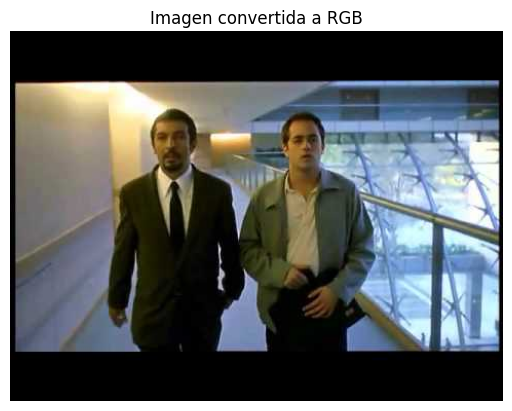

In [6]:
# Conversión de BGR a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar imagen con matplotlib
plt.imshow(img_rgb)
plt.title("Imagen convertida a RGB")
plt.axis("off")
plt.show()

### 1.2 **Ejercicio 2:** Convertir la Imagen a Escala de Grises

El detector Haar necesita la imagen en escala de grises.

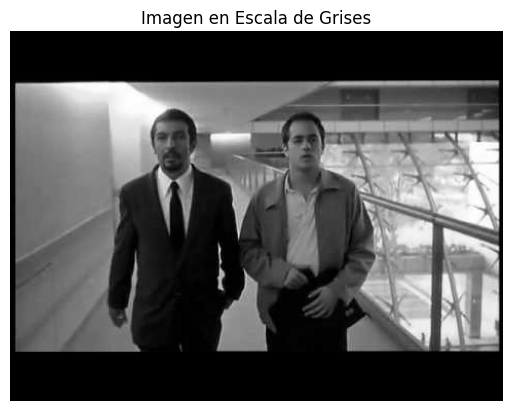

In [7]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Mostrar la imagen en escala de grises con matplotlib
plt.imshow(img_gray, cmap='gray')
plt.title("Imagen en Escala de Grises")
plt.axis("off")
plt.show()


### 1.3 **Ejercicio 3:** Cargar Clasificador y Detectar Rostros

Cargamos el archivo `.xml` y usamos el método `detectMultiScale` sobre la imagen gris. Este método busca caras en diferentes tamaños y devuelve una lista de rectángulos `(x, y, ancho, alto)` por cada cara encontrada.

In [8]:
# Cargar el clasificador Haar desde el archivo .xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Verificar si se cargó correctamente
if face_cascade.empty():
    raise IOError("No se pudo cargar el clasificador Haar. Verifica que el archivo exista.")

# Detectar rostros en la imagen en escala de grises
faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5)

# Mostrar cuántos rostros se detectaron
print(f"Se detectaron {len(faces)} rostro(s).")

# Mostrar coordenadas de cada rostro detectado
for i, (x, y, w, h) in enumerate(faces):
    print(f"Rostro {i+1}: x={x}, y={y}, ancho={w}, alto={h}")

Se detectaron 2 rostro(s).
Rostro 1: x=267, y=89, ancho=43, alto=43
Rostro 2: x=135, y=85, ancho=45, alto=45


### 1.4 **Ejercicio 4:** Dibujar Bounding Boxes y Nombres

Visualizamos los resultados dibujando rectángulos y nombres sobre la imagen RGB.

**Tarea:** Dibuja la bounding box de Darín en rojo y la de Pauls en verde. Añade sus nombres encima.
*Asumiremos que `faces[0]` es Pauls y `faces[1]` es Darín según el orden de detección típico (puede variar).*

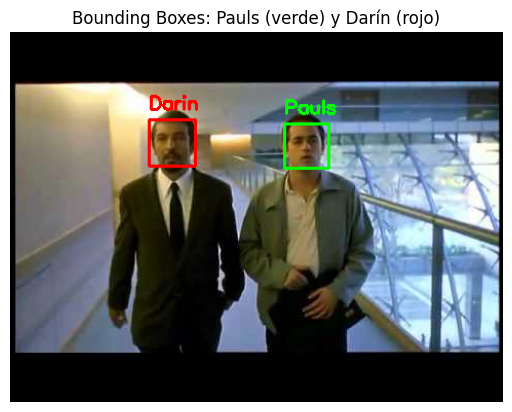

In [9]:
# Asegúrate de tener 'faces' con al menos 2 rostros detectados
if len(faces) >= 2:
    # Asumimos que faces[0] es Pauls y faces[1] es Darín
    (x_p, y_p, w_p, h_p) = faces[0]  # Pauls
    (x_d, y_d, w_d, h_d) = faces[1]  # Darín

    # Dibujar bounding box Pauls (verde)
    cv2.rectangle(img_rgb, (x_p, y_p), (x_p + w_p, y_p + h_p), (0, 255, 0), 2)
    cv2.putText(img_rgb, 'Pauls', (x_p, y_p - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Dibujar bounding box Darín (rojo)
    cv2.rectangle(img_rgb, (x_d, y_d), (x_d + w_d, y_d + h_d), (255, 0, 0), 2)
    cv2.putText(img_rgb, 'Darin', (x_d, y_d - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Mostrar la imagen con matplotlib
    plt.imshow(img_rgb)
    plt.title("Bounding Boxes: Pauls (verde) y Darín (rojo)")
    plt.axis("off")
    plt.show()
else:
    print("Se necesitan al menos dos rostros detectados para este ejercicio.")

## Sección 2: Detección de Landmarks Faciales con LBF

**Concepto:** Una vez ubicada una cara (con su bounding box), podemos usar un detector de landmarks para encontrar puntos precisos en ella. El método LBF (Local Binary Features) usa un modelo (`lbfmodel.yaml`) entrenado para localizar 68 puntos estándar en el rostro. Necesita la imagen en escala de grises y las bounding boxes como entrada.

### 2.1 Cargar Modelo y Detectar Landmarks

In [10]:
# Cargar el detector de landmarks y aplicarlo

if img_gray is not None and len(faces) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector.fit(img_gray, faces)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('faces').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 2 rostro(s).


### 2.2 Procesar y Visualizar Landmarks (Pauls)

Los landmarks vienen en un formato específico (array 3D, tipo float). Los procesamos para obtener un array 2D de enteros `(x, y)` para cada uno de los 68 puntos del primer rostro (Pauls) y los dibujamos.

Landmarks Pauls procesados. Forma: (68, 2)

Dibujando landmarks de Pauls (verde):


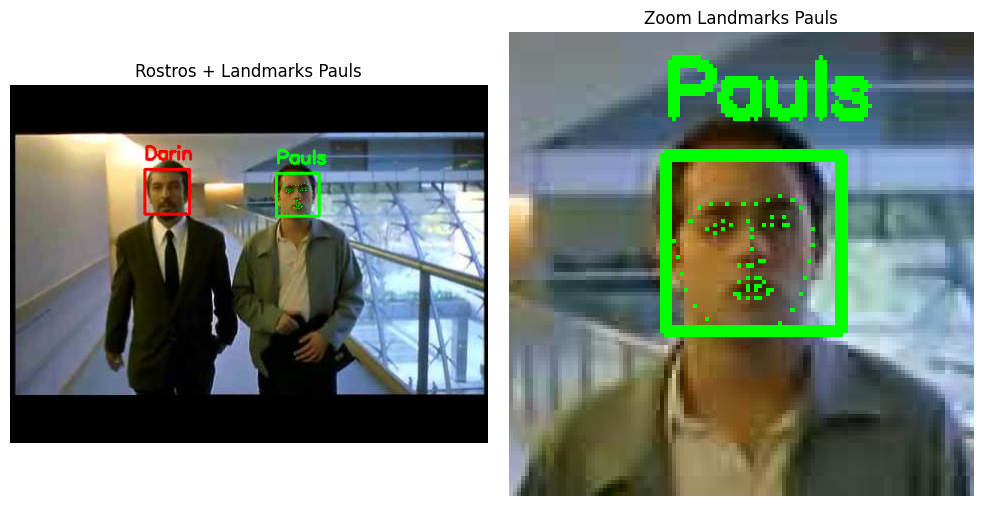

In [11]:
if all_landmarks is not None and len(all_landmarks) >= 1:
    # Landmarks del primer rostro (índice 0)
    landmarks_pauls = all_landmarks[0][0].astype(int)
    print("Landmarks Pauls procesados. Forma:", landmarks_pauls.shape)

    # Dibujar los landmarks de Pauls (verde)
    print("\nDibujando landmarks de Pauls (verde):")
    img_copy = img_rgb.copy()  # Evita dibujar directamente sobre la imagen original
    for x, y in landmarks_pauls:
        cv2.circle(img_copy, (x, y), 0, (0, 255, 0), 1)

    # Definir zona de zoom basada en los landmarks
    x_min = landmarks_pauls[:, 0].min()
    x_max = landmarks_pauls[:, 0].max()
    y_min = landmarks_pauls[:, 1].min()
    y_max = landmarks_pauls[:, 1].max()

    margin = 40
    x_min = max(x_min - margin, 0)
    y_min = max(y_min - margin, 0)
    x_max = min(x_max + margin, img_copy.shape[1])
    y_max = min(y_max + margin, img_copy.shape[0])

    # Mostrar ambas imágenes lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img_copy)
    axs[0].set_title("Rostros + Landmarks Pauls")
    axs[0].axis('off')

    axs[1].imshow(img_copy[y_min:y_max, x_min:x_max])
    axs[1].set_title("Zoom Landmarks Pauls")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("No hay landmarks disponibles para procesar.")


### 2.3 **Ejercicio 5:** Procesar y Dibujar Landmarks (Darín)

**Tarea:** Haz lo mismo que en la celda anterior pero para el segundo rostro (Darín, índice 1) y dibuja sus landmarks en rojo sobre la *misma* imagen `img_rgb`.

Landmarks Darín procesados. Forma: (68, 2)

Dibujando landmarks de Darín (rojo):


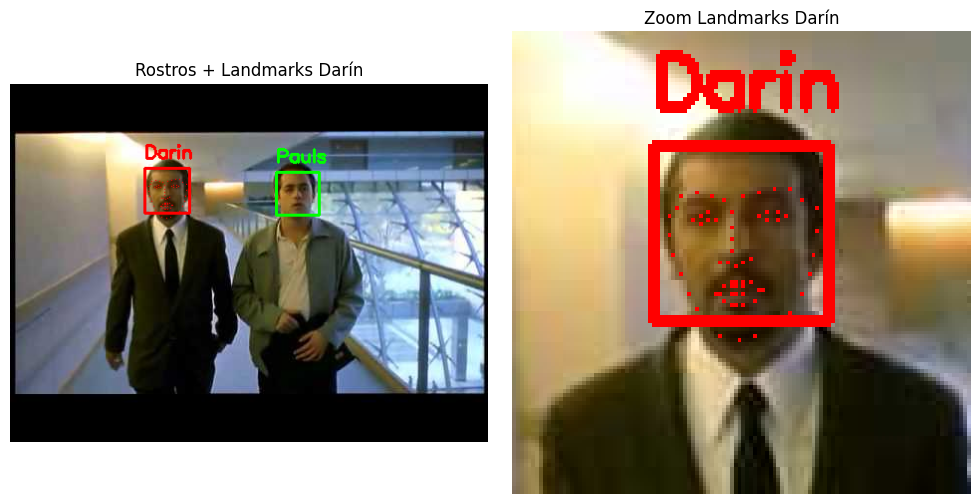

In [12]:
if all_landmarks is not None and len(all_landmarks) >= 2:
    # Procesar landmarks Darín (índice 1)
    landmarks_darin = all_landmarks[1][0].astype(int)
    print("Landmarks Darín procesados. Forma:", landmarks_darin.shape)

    # Crear copia de la imagen original
    img_copy = img_rgb.copy()

    # Dibujar landmarks de Darín (rojo)
    print("\nDibujando landmarks de Darín (rojo):")
    for x, y in landmarks_darin:
        cv2.circle(img_copy, (x, y), 0, (255, 0, 0), 1)

    # Calcular región para el zoom automáticamente usando los landmarks
    x_min = landmarks_darin[:, 0].min()
    x_max = landmarks_darin[:, 0].max()
    y_min = landmarks_darin[:, 1].min()
    y_max = landmarks_darin[:, 1].max()

    margin = 40
    x_min = max(x_min - margin, 0)
    x_max = min(x_max + margin, img_copy.shape[1])
    y_min = max(y_min - margin, 0)
    y_max = min(y_max + margin, img_copy.shape[0])

    # Mostrar imagen completa y zoom en Darín, lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img_copy)
    axs[0].set_title("Rostros + Landmarks Darín")
    axs[0].axis('off')

    axs[1].imshow(img_copy[y_min:y_max, x_min:x_max])
    axs[1].set_title("Zoom Landmarks Darín")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

elif all_landmarks is None:
    print("No hay landmarks disponibles.")
elif len(all_landmarks) < 2:
    print("Solo se detectó 1 rostro, no se pueden procesar landmarks para Darín.")


## Sección 3: Selección y Aplicación de Landmarks

Conociendo el índice de cada landmark (ver imagen de la malla), podemos seleccionar y usar solo los puntos que nos interesan para tareas específicas.

### 3.1 **Ejercicio 6:** Dibujar Ojos y Boca (Pauls)

**Tarea:**
1.  Define listas con los índices correspondientes a los ojos y la boca.
2.  Crea una **copia limpia** de la imagen RGB original (`img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`).
3.  Itera sobre `landmarks_pauls`.
4.  Dibuja solo los puntos de ojos y boca sobre `img_con_partes` usando colores distintos (Magenta, Azul, Cian).
5.  Muestra un zoom en Pauls de la imagen resultante.

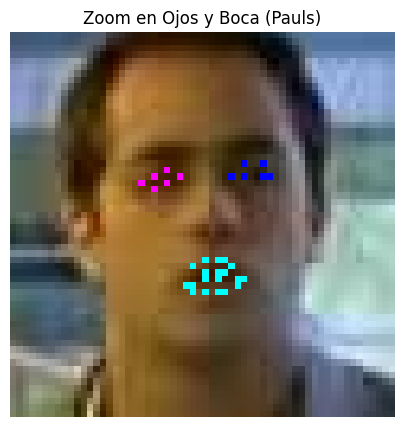

In [18]:
# Índices adaptados al modelo de 68 puntos
ojos_izq = list(range(36, 42))
ojos_der = list(range(42, 48))
boca = list(range(48, 68))

# Crear copia limpia en formato RGB
img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Dibujar puntos (ya están en píxeles, no necesitas escalar si landmarks_pauls ya viene así)
for i, (x, y) in enumerate(landmarks_pauls):
    if i in ojos_izq:
        color = (255, 0, 255)  # Magenta
    elif i in ojos_der:
        color = (0, 0, 255)    # Azul
    elif i in boca:
        color = (0, 255, 255)  # Cian
    else:
        continue

    cv2.circle(img_con_partes, (int(x), int(y)), 0, color, 1)

# Recorte para mostrar zoom
x_coords = [int(landmarks_pauls[i][0]) for i in ojos_izq + ojos_der + boca]
y_coords = [int(landmarks_pauls[i][1]) for i in ojos_izq + ojos_der + boca]

x_min, x_max = max(min(x_coords) - 20, 0), min(max(x_coords) + 20, img.shape[1])
y_min, y_max = max(min(y_coords) - 20, 0), min(max(y_coords) + 20, img.shape[0])

zoom = img_con_partes[y_min:y_max, x_min:x_max]

# Mostrar imagen
plt.figure(figsize=(5, 5))
plt.imshow(zoom)
plt.title("Zoom en Ojos y Boca (Pauls)")
plt.axis('off')
plt.show()

## Sección 4: Conclusión y Próximos Pasos

En este laboratorio, hemos integrado la detección de rostros con la localización de landmarks faciales usando OpenCV. Vimos cómo preparar la imagen, aplicar los detectores y visualizar los resultados, incluyendo la selección de puntos específicos.

Estos landmarks son bloques de construcción para aplicaciones más avanzadas como:
*   **Detección de Somnolencia/Bostezos:** Calculando Eye Aspect Ratio (EAR) y Mouth Aspect Ratio (MAR).
*   **Análisis de Expresiones Faciales.**
*   **Realidad Aumentada.**

**Ideas para continuar:**
*   Investiga y calcula EAR y MAR para los rostros detectados.
*   Aplica este flujo de trabajo a otras imágenes o a los fotogramas de un video.

In [19]:
import numpy as np

# Cálculo de Eye Aspect Ratio (EAR)
def calcular_ear(ojo):
    # ojo: lista de 6 puntos [(x1,y1), ..., (x6,y6)]
    A = np.linalg.norm(ojo[1] - ojo[5])  # distancia vertical
    B = np.linalg.norm(ojo[2] - ojo[4])  # distancia vertical
    C = np.linalg.norm(ojo[0] - ojo[3])  # distancia horizontal
    ear = (A + B) / (2.0 * C)
    return ear

# Cálculo de Mouth Aspect Ratio (MAR)
def calcular_mar(boca):
    # boca: lista de 20 puntos (puntos 48 al 67)
    A = np.linalg.norm(boca[13] - boca[19])  # 62-66 (línea vertical interior)
    B = np.linalg.norm(boca[14] - boca[18])  # 63-65
    C = np.linalg.norm(boca[15] - boca[17])  # 64-64
    D = np.linalg.norm(boca[12] - boca[16])  # 61-67 (línea horizontal interior)
    mar = (A + B + C) / (2.0 * D)
    return mar

In [20]:
# Extraer puntos para ojos y boca
ojo_izq_pts = landmarks_pauls[36:42]
ojo_der_pts = landmarks_pauls[42:48]
boca_pts = landmarks_pauls[48:68]

# Convertir a NumPy arrays para usar en cálculo
ojo_izq = np.array(ojo_izq_pts)
ojo_der = np.array(ojo_der_pts)
boca = np.array(boca_pts)

# Calcular EAR para cada ojo y obtener el promedio
ear_izq = calcular_ear(ojo_izq)
ear_der = calcular_ear(ojo_der)
ear = (ear_izq + ear_der) / 2.0

# Calcular MAR
mar = calcular_mar(boca)

# Mostrar resultados
print(f"EAR (promedio ojos): {ear:.3f}")
print(f"MAR (boca): {mar:.3f}")


EAR (promedio ojos): 0.331
MAR (boca): 0.141


# Conclusión

EAR de 0.331 indica que los ojos están abiertos de forma normal. Este valor está dentro del rango típico para ojos abiertos (habitualmente > 0.25). No se detectan signos de parpadeo ni somnolencia.

MAR de 0.141 sugiere que la boca está cerrada o ligeramente abierta. Valores más altos (por encima de ~0.6) suelen asociarse con bostezos o expresiones faciales activas como hablar o gritar.